# 6.6 Sourcing & Analyzing Time Series Data


Daniel Rodelli
________________
_______________
#### INTRODUCTION
The COVID-19 data for Germany that I have analized so far show repeated increases and decreases in both number of cases and deaths nationwide.
The porpouse of this time-series analysis is to observe in detail the behavior of the variables, and ultimately build a model to forecast the future number of cases. 
Since the beginning of the pandemic, the German Federal Gorvermnent dictated the guidelines for each State to help contain the spread of the virus. These guidelines are used to decide whether the lockdown and social distancing measures are to be relaxed or strengthened, based on the weekly incidence of the virus, the incidente being defined as the weekly average number of cases every 100 thousand inhabitants. 

In this time series analysis I will follow this definition of incidence to try to forecast the next season behavior.
I will use the nationwide number of cases, normalized by population, and a running average spanning 7 days.

#### Table of Contents
1. Import Libraries and Dataset
2. Dataframe Preparation
3. Time Series Analysis
        3.1 First Derivative
        3.2 Second Derivative
4. ARIMA modelling

### 1 Import Libraties and Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from pylab import rcParams
import os
import warnings 

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ARIMA

In [3]:
#setting the style for the charts
plt.style.use('fivethirtyeight')

# Define a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7

In [4]:
#setting the data path
path = r'C:\Users\daniel\Documents\CareerFoundry\Immersion_achievement6'

In [5]:
#importing the dataset
df = pd.read_csv(os.path.join(path,'data', 'prepared_data','df_cleaned.csv'))

In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,State,Age_group,Gender,Date,N_cases,N_deaths,N_recoveries,day,...,year,weekday,N_cases/100k,N_deaths/100k,N_recoveries/100k,climate_flag,cases/density,deaths/density,recoveries/density,density_flag
0,0,0,Baden-Württemberg,A00-A04,F,2020-03-02,1,0,1,2,...,2020,0,0.009007,0.0,0.009007,oceanic,0.003247,0.0,0.003247,mid_density
1,1,1,Baden-Württemberg,A00-A04,F,2020-03-13,3,0,3,13,...,2020,4,0.027020,0.0,0.027020,oceanic,0.009740,0.0,0.009740,mid_density
2,2,2,Baden-Württemberg,A00-A04,F,2020-03-14,4,0,4,14,...,2020,5,0.036026,0.0,0.036026,oceanic,0.012987,0.0,0.012987,mid_density
3,3,3,Baden-Württemberg,A00-A04,F,2020-03-15,1,0,1,15,...,2020,6,0.009007,0.0,0.009007,oceanic,0.003247,0.0,0.003247,mid_density
4,4,4,Baden-Württemberg,A00-A04,F,2020-03-16,3,0,3,16,...,2020,0,0.027020,0.0,0.027020,oceanic,0.009740,0.0,0.009740,mid_density


### 2 Dataframe Preapration

In [7]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'day','year','weekday','N_cases', 'N_deaths', 'N_recoveries',
                'cases/density', 'deaths/density', 'recoveries/density'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102850 entries, 0 to 102849
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              102850 non-null  object 
 1   Age_group          102850 non-null  object 
 2   Gender             102850 non-null  object 
 3   Date               102850 non-null  object 
 4   month              102850 non-null  int64  
 5   N_cases/100k       102850 non-null  float64
 6   N_deaths/100k      102850 non-null  float64
 7   N_recoveries/100k  102850 non-null  float64
 8   climate_flag       102850 non-null  object 
 9   density_flag       102850 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 7.8+ MB


In [74]:
pv=df.pivot_table(index=['Date'], values=['N_cases/100k'], aggfunc='sum')

pv.reset_index(inplace=True)
pv.head()

,Date,N_cases/100k
0,2020-01-01,0.394064
1,2020-01-02,0.354433
2,2020-01-03,0.393274
3,2020-01-04,0.470765
4,2020-01-05,0.381619


In [75]:
pv['datetime'] = pd.to_datetime(pv['Date']) # Create a datetime column from "Date.""
pv.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.

pv['N_cases/100k_MA']=pv['N_cases/100k'].rolling(7).mean().shift(-3)#7-days moving average
pv.dropna(inplace=True)
pv=pv.set_index('datetime')
pv.head()

,N_cases/100k,N_cases/100k_MA
datetime,,
2020-01-04,0.470765,0.354992
2020-01-05,0.381619,0.334715
2020-01-06,0.265076,0.305710
2020-01-07,0.225717,0.259071
2020-01-08,0.252122,0.214254


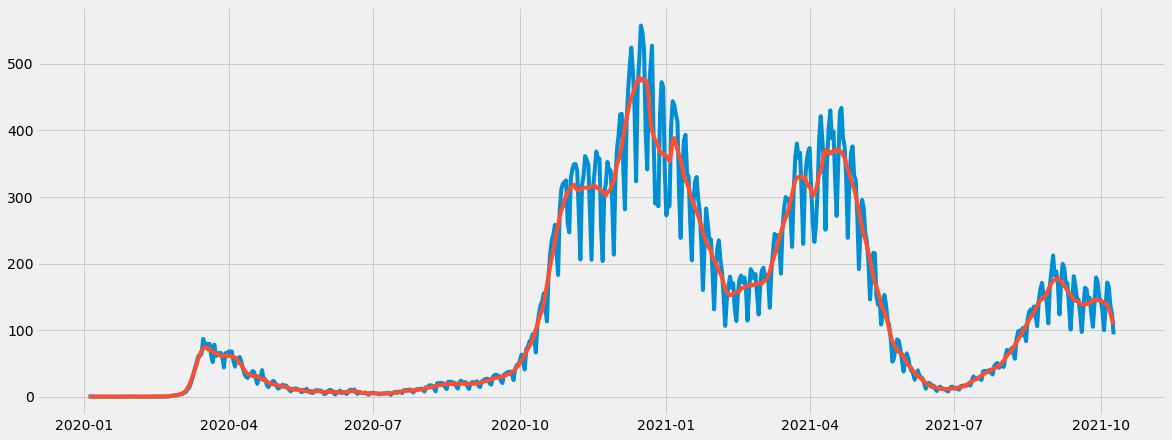

In [18]:
plt.plot(pv)

In [76]:
pv_date=pv.iloc[::7, :]

In [80]:
pv_date.reset_index(inplace=True)
pv_date.drop(columns=['N_cases/100k', 'N_cases/100k_MA'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [81]:
pv_date

,index,datetime
0,0,2020-01-04
1,1,2020-01-11
2,2,2020-01-18
3,3,2020-01-25
4,4,2020-02-01
...,...,...
87,87,2021-09-05
88,88,2021-09-12
89,89,2021-09-19
90,90,2021-09-26


In [84]:
pv.reset_index(inplace=True)
pv.drop(columns=['N_cases/100k_MA'], inplace=True)

In [85]:
pv=pv.groupby(pv.index // 7).sum()

In [86]:
pv.head()

,N_cases/100k
0,1.813500
1,0.943836
2,0.671428
3,1.311880
4,1.082645


In [93]:
pv_date['N_cases/100k']=pv['N_cases/100k']

In [94]:
pv_date

,index,datetime,N_cases/100k
0,0,2020-01-04,1.813500
1,1,2020-01-11,0.943836
2,2,2020-01-18,0.671428
3,3,2020-01-25,1.311880
4,4,2020-02-01,1.082645
...,...,...,...
87,87,2021-09-05,1166.277010
88,88,2021-09-12,1008.889192
89,89,2021-09-19,972.047513
90,90,2021-09-26,1015.771277


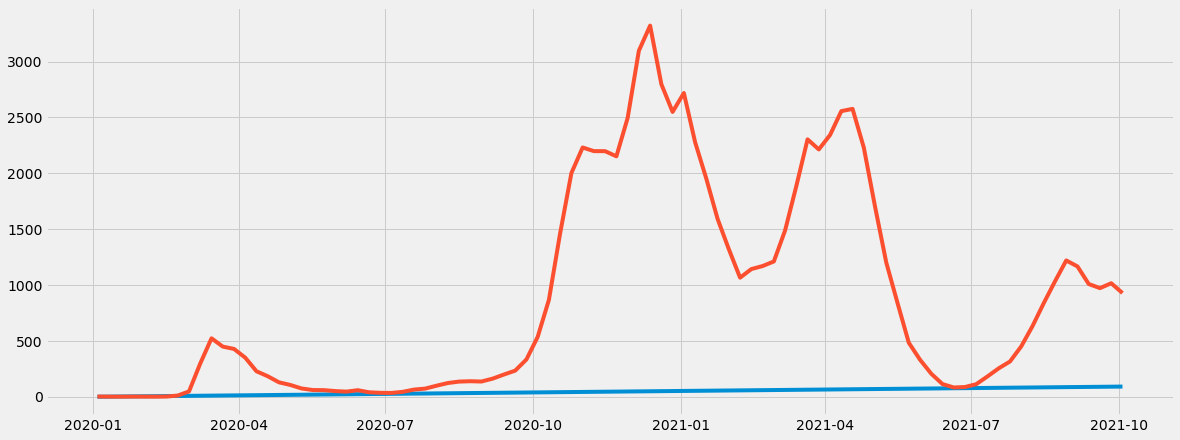

In [96]:
plt.plot(pv_date.set_index('datetime'))

In [19]:
pv.drop(columns=['N_cases/100k'], inplace=True)

In [20]:
pv.head()

,N_cases/100k_MA
datetime,
2020-01-04,0.354992
2020-01-05,0.334715
2020-01-06,0.305710
2020-01-07,0.259071
2020-01-08,0.214254


### 3 Time Series Analysis
I will select a subset of dates, starting from the 1st of March 2020 to the first of October 2021 (This is because the algorithm for the decomposition of the timeseries returned errors relative to the frequency, and the easiest way to fix it was for me to select a subset of dates). The subset cuts the first two months of data, where the number of cases and deaths was minimal, and still keeps all the main waves of the Pandemic.

In [21]:
pv.reset_index(inplace=True)
subset=pv.loc[(pv['datetime'] >= '2020-03-01') & (pv['datetime'] < '2021-10-01')]
subset=subset.set_index('datetime')

In [22]:
subset.head()

,N_cases/100k_MA
datetime,
2020-03-01,3.436171
2020-03-02,4.153953
2020-03-03,5.284011
2020-03-04,6.806493
2020-03-05,8.950285


In [26]:
decomposition = sm.tsa.seasonal_decompose(subset, model='multiplicative')

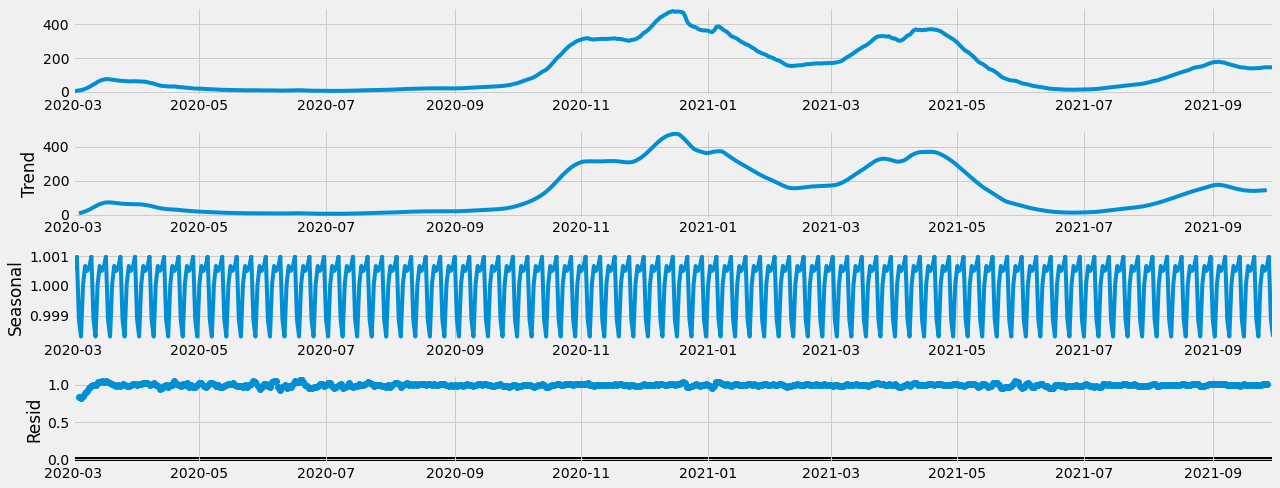

In [27]:
decomposition.plot()
plt.show()

- Level and trend: the curves are very similar, suggesting that the data is smoothed
- Seasonal: there is a strong regular fluctuation in the seasonality, apparently composed of at least two terms.
- Residual: there is quite some noise in the central part of the series.

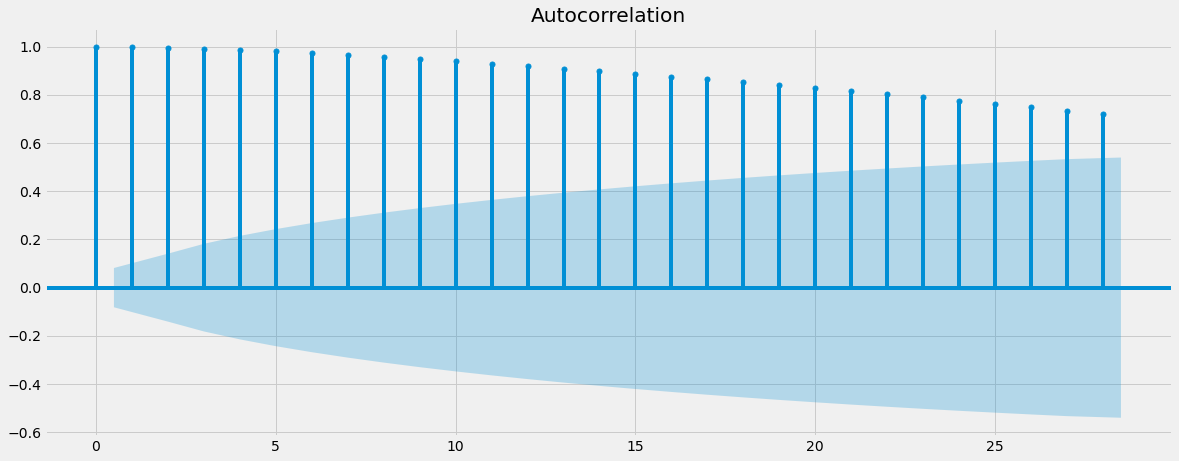

In [28]:
plot_acf(subset)
plt.show()

The series shows strong autocorrelation, with all lags above the confidence limit. To make the series stationary, i will derivate it at least one time.

In [29]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.



def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


In [30]:
# Apply the test using the function on the time series
dickey_fuller(subset['N_cases/100k_MA'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.158080
p-value                          0.221810
Number of Lags Used             15.000000
Number of Observations Used    563.000000
Critical Value (1%)             -3.442019
Critical Value (5%)             -2.866687
Critical Value (10%)            -2.569511
dtype: float64


The test statistic is -2.16 and the p-value is 0.22 which indicates the test result is not significant as it is more than 0.05. Using the critical value (5%) which is -2.86, it is much smaller than the test statistic. This means you cannot reject the null hypothesis. 

##### 3. 1 First Derivative

In [31]:
subset_diff=subset-subset.shift(1)
subset_diff.dropna(inplace=True)

In [32]:
subset_diff.head()

,N_cases/100k_MA
datetime,
2020-03-02,0.717782
2020-03-03,1.130059
2020-03-04,1.522482
2020-03-05,2.143792
2020-03-06,3.186806


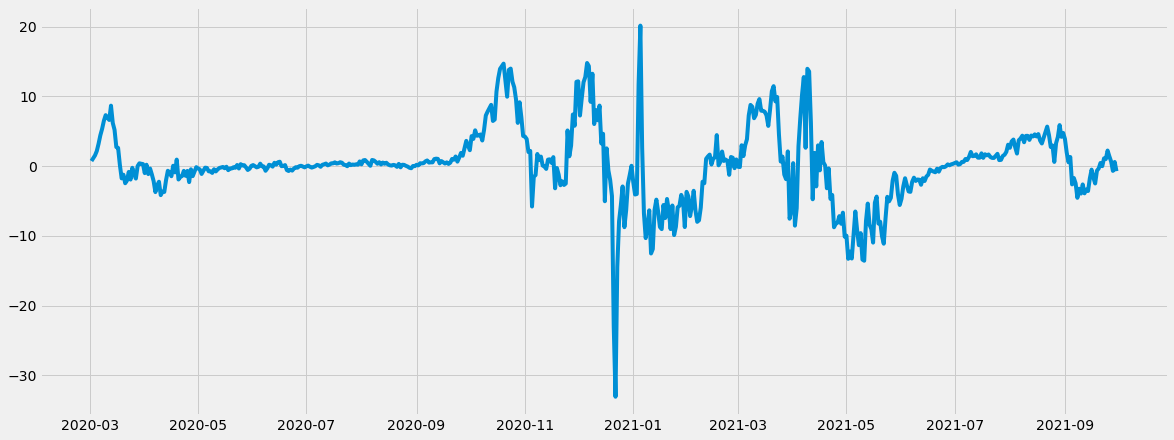

In [33]:
plt.plot(subset_diff)

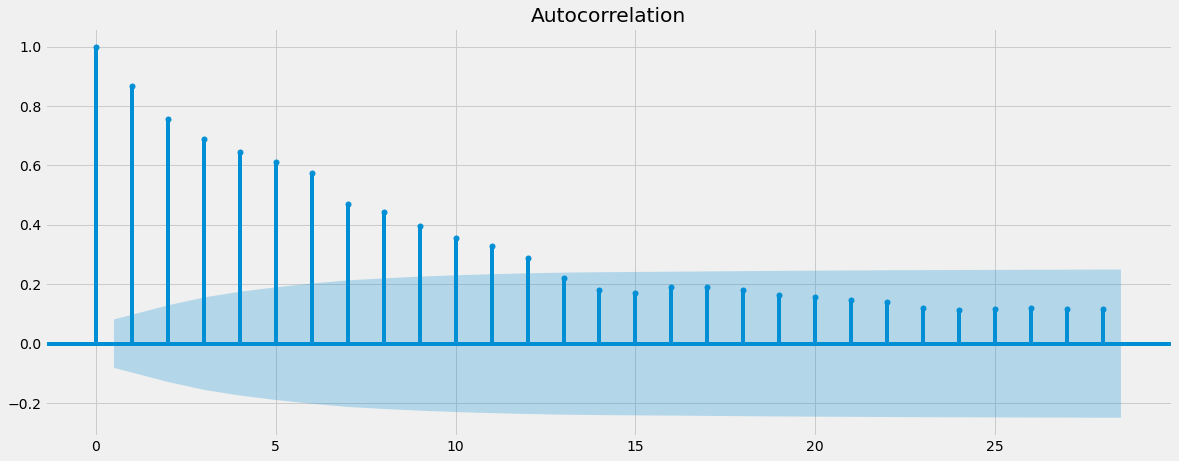

In [34]:
plot_acf(subset_diff)
plt.show()

There are numerous lags (13) out of the confidence interval. This means that there are still autocorrelated data and that the series in not stationary

In [35]:
dickey_fuller(subset_diff['N_cases/100k_MA'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.875361
p-value                          0.002224
Number of Lags Used             14.000000
Number of Observations Used    563.000000
Critical Value (1%)             -3.442019
Critical Value (5%)             -2.866687
Critical Value (10%)            -2.569511
dtype: float64


The Autocorrelation plot shows that there is still some strong autocorrelation in the differenciated dataframe, but according to the Dickey-Fuller test, the Test Statistic is valid (lower than than the critical value of 1%). 
I will differenciate a second time to see if the results from the Autocorrelation plot improve.

##### 3. 2 Second Derivative

In [36]:
subset_diff2=subset_diff-subset_diff.shift(1)
subset_diff2.dropna(inplace=True)

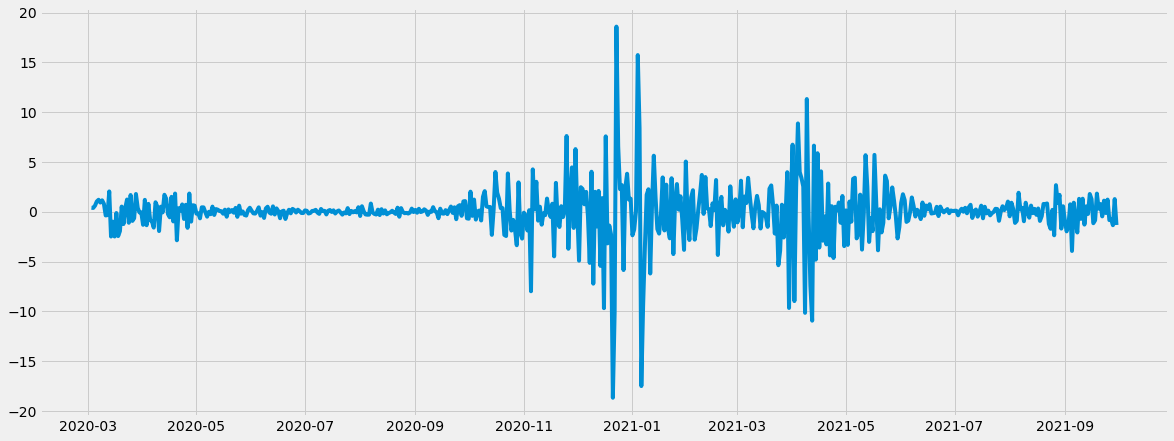

In [37]:
plt.plot(subset_diff2)

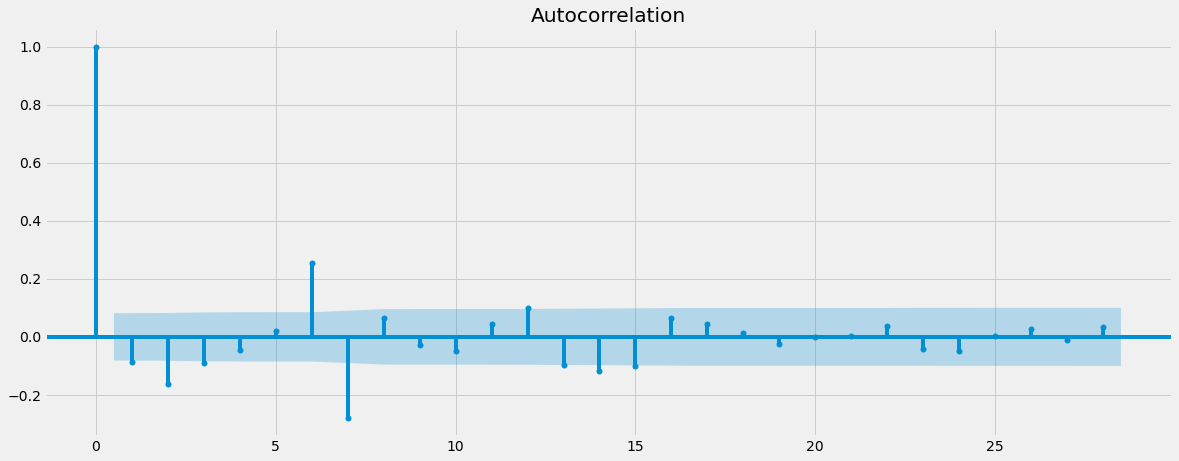

In [38]:
plot_acf(subset_diff2)
plt.show()

There are still a few autocorrelated terms outside the confidence interval, but since there are no  consecutive autocorrelated terms, i will not need to differenciate a third time.

In [39]:
dickey_fuller(subset_diff2['N_cases/100k_MA'])

Dickey-Fuller Stationarity test:
Test Statistic                -8.635220e+00
p-value                        5.614608e-14
Number of Lags Used            1.300000e+01
Number of Observations Used    5.630000e+02
Critical Value (1%)           -3.442019e+00
Critical Value (5%)           -2.866687e+00
Critical Value (10%)          -2.569511e+00
dtype: float64


With differencing a second time, the test-statistic (-8.63) is now smaller than the critical values at 5% (-2.8) and even at 1% (-3.44). The null hypothesis can be rejected and the series is now stationary. The test result is also significant as the p-value is less than 0.05.

### 4. ARIMA Model

In [64]:
"""Defining the ARIMA MODEL function.
The function is to be passed 4 arguments: 
1. the train set 
2. the test set 
3. the order(p,d,q)
3.the shape of the test set."""

from statsmodels.tsa.api import ARIMA # Import the model you need

def arima_model(train, test, order, test_shape):
    
    model = ARIMA(train, order=order)  
    fitted = model.fit()  
    print(fitted.summary()) # Check model summary

    # Forecast
    fc, se, conf = fitted.forecast(test_shape, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 41 is the shape of the test set

    # Make into pandas series
    fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
    lower_series = pd.Series(conf[:, 0], index=test.index) # lower bound of the confidence interval
    upper_series = pd.Series(conf[:, 1], index=test.index) # Upper bound of the confidence interval

    # Plot
    plt.figure(figsize=(12,4), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.05, label='confidence interval') # This creates the confidence interval
    plt.title('Forecast vs Actuals')
    plt.ylim(0,train['N_cases/100k_MA'].max())
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [41]:
subset_diff

,N_cases/100k_MA
datetime,
2020-03-02,0.717782
2020-03-03,1.130059
2020-03-04,1.522482
2020-03-05,2.143792
2020-03-06,3.186806
...,...
2021-09-26,1.392674
2021-09-27,0.642584
2021-09-28,-0.696794


In [43]:
#reset index
subset.reset_index(inplace=True)
#train-test split
train=subset.loc[(subset['datetime']<'2021-07-15')]
test=subset.loc[(subset['datetime']>='2021-07-15')]

test=test.set_index('datetime')
train=train.set_index('datetime')

In [44]:
test.shape

(78, 1)

In [45]:
test.head()

,N_cases/100k_MA
datetime,
2021-07-15,27.200576
2021-07-16,29.020783
2021-07-17,30.194668
2021-07-18,31.880512
2021-07-19,33.413615


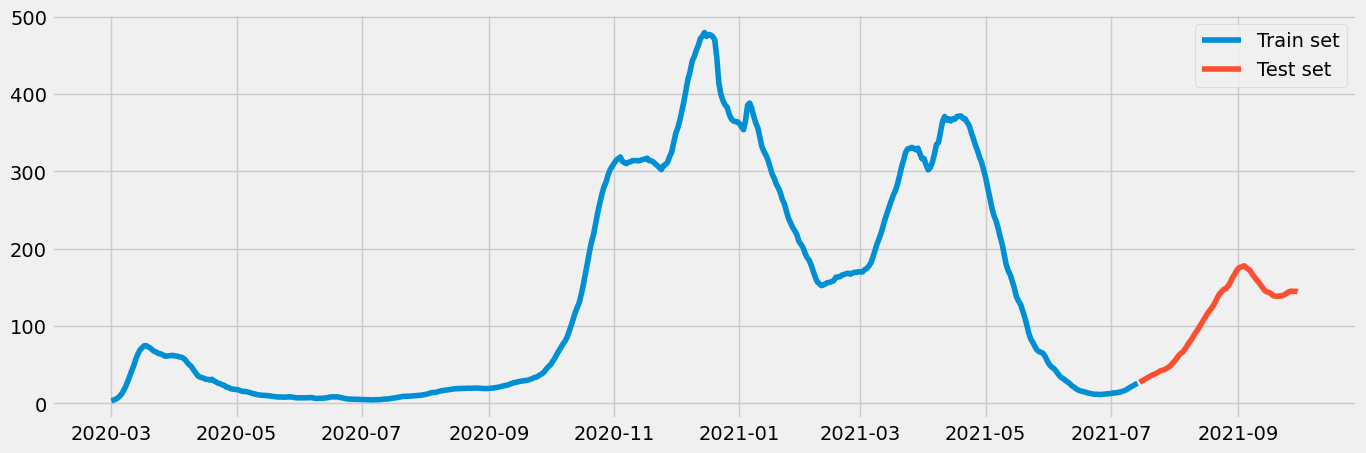

In [46]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(train, label='Train set')
plt.plot(test, label='Test set')
plt.legend()

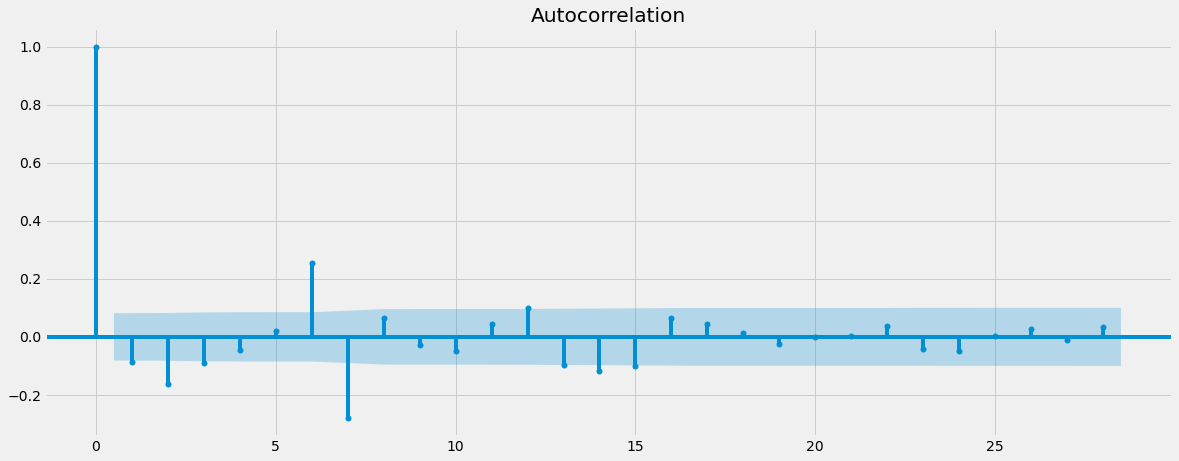

In [47]:
#subset_diff=subset_diff.set_index('datetime')
plot_acf(subset_diff2)
plt.show()

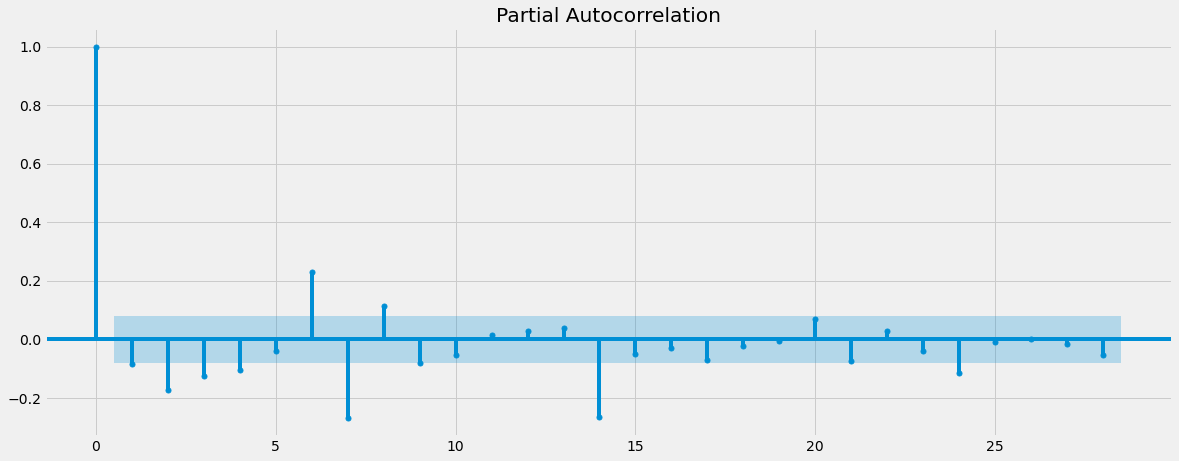

In [48]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(subset_diff2)
#plt.ylim(-10, 10)
plt.show()

In [49]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

                             ARIMA Model Results                              
Dep. Variable:     D2.N_cases/100k_MA   No. Observations:                  499
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1214.434
Method:                       css-mle   S.D. of innovations              2.750
Date:                Thu, 11 Nov 2021   AIC                           2440.867
Time:                        21:28:11   BIC                           2466.143
Sample:                    03-03-2020   HQIC                          2450.786
                         - 07-14-2021                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0053      0.007     -0.710      0.478      -0.020       0.009
ar.L1.D2.N_cases/100k_MA     1.4784      0.188      7.847      0.000       1.109       1.

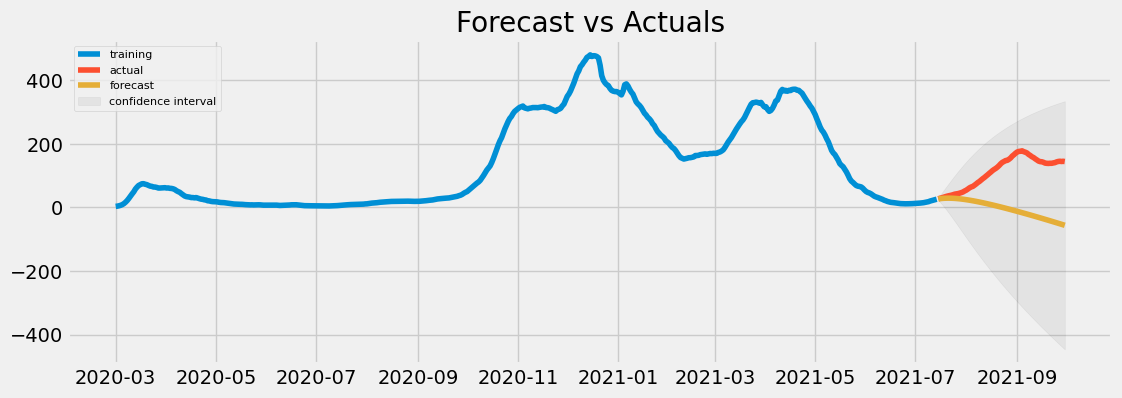

In [51]:
arima_model(train, test, (2,2,2),78)

The Test data fall inside the confidence limit of the model, but the model forecasts a decrease in numbers of cases, while the actual data show an increase.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

                             ARIMA Model Results                              
Dep. Variable:     D2.N_cases/100k_MA   No. Observations:                  499
Model:                 ARIMA(2, 2, 4)   Log Likelihood               -1201.881
Method:                       css-mle   S.D. of innovations              2.687
Date:                Sat, 13 Nov 2021   AIC                           2419.761
Time:                        13:03:29   BIC                           2453.462
Sample:                    03-03-2020   HQIC                          2432.987
                         - 07-14-2021                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0001      0.076     -0.002      0.999      -0.149       0.148
ar.L1.D2.N_cases/100k_MA    -0.4565      0.050     -9.149      0.000      -0.554      -0.

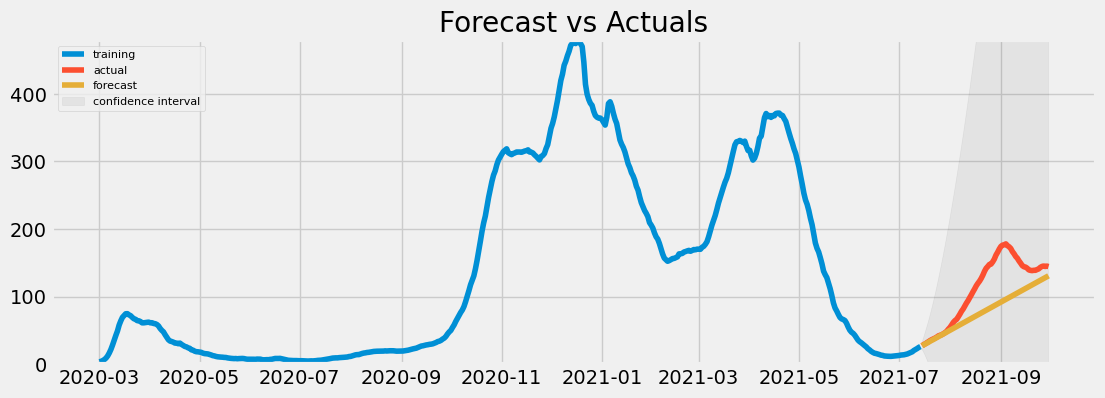

In [65]:
arima_model(train, test, (2,2,4),78)

The train data fall inside the confidence limit, and the model and the actual data both show an increase in the number of cases. All the coefficient are statistically relevant, and the end points of the forecast and real data are quite close to each other.